In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

C:\Users\timot\AppData\Local\Temp\ipykernel_21904\356493943.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Read Train data

In [3]:

train_home_team_statistics_df = pd.read_csv('./datas_final/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./datas_final/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('./datas_final/Y_train.csv', index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})


In [4]:
train_data.head()

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,6.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,8.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,7.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,0.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,NaN,2.0
4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0


In [5]:
train_scores.head()

,HOME_WINS,DRAW,AWAY_WINS
ID,,,
0,0,0,1
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0


## Benchmark

We try to model if AWAY wins

In [ ]:
train_new_y = train_scores['AWAY_WINS']

### train, valid test split

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)


### xgb model

In [11]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 2,
    'eval_metric':'mlogloss'
    }


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)


[0]	train-mlogloss:0.68338	eval-mlogloss:0.68785
[1]	train-mlogloss:0.67389	eval-mlogloss:0.68266
[2]	train-mlogloss:0.66467	eval-mlogloss:0.67757
[3]	train-mlogloss:0.65574	eval-mlogloss:0.67304
[4]	train-mlogloss:0.64724	eval-mlogloss:0.66849
[5]	train-mlogloss:0.63894	eval-mlogloss:0.66438
[6]	train-mlogloss:0.63052	eval-mlogloss:0.66062
[7]	train-mlogloss:0.62230	eval-mlogloss:0.65697
[8]	train-mlogloss:0.61454	eval-mlogloss:0.65359
[9]	train-mlogloss:0.60701	eval-mlogloss:0.65015
[10]	train-mlogloss:0.59949	eval-mlogloss:0.64682
[11]	train-mlogloss:0.59224	eval-mlogloss:0.64347
[12]	train-mlogloss:0.58520	eval-mlogloss:0.64026
[13]	train-mlogloss:0.57876	eval-mlogloss:0.63741
[14]	train-mlogloss:0.57188	eval-mlogloss:0.63467
[15]	train-mlogloss:0.56536	eval-mlogloss:0.63191
[16]	train-mlogloss:0.55888	eval-mlogloss:0.62946
[17]	train-mlogloss:0.55254	eval-mlogloss:0.62681
[18]	train-mlogloss:0.54669	eval-mlogloss:0.62444
[19]	train-mlogloss:0.54078	eval-mlogloss:0.62231
[20]	train

### Some analysis

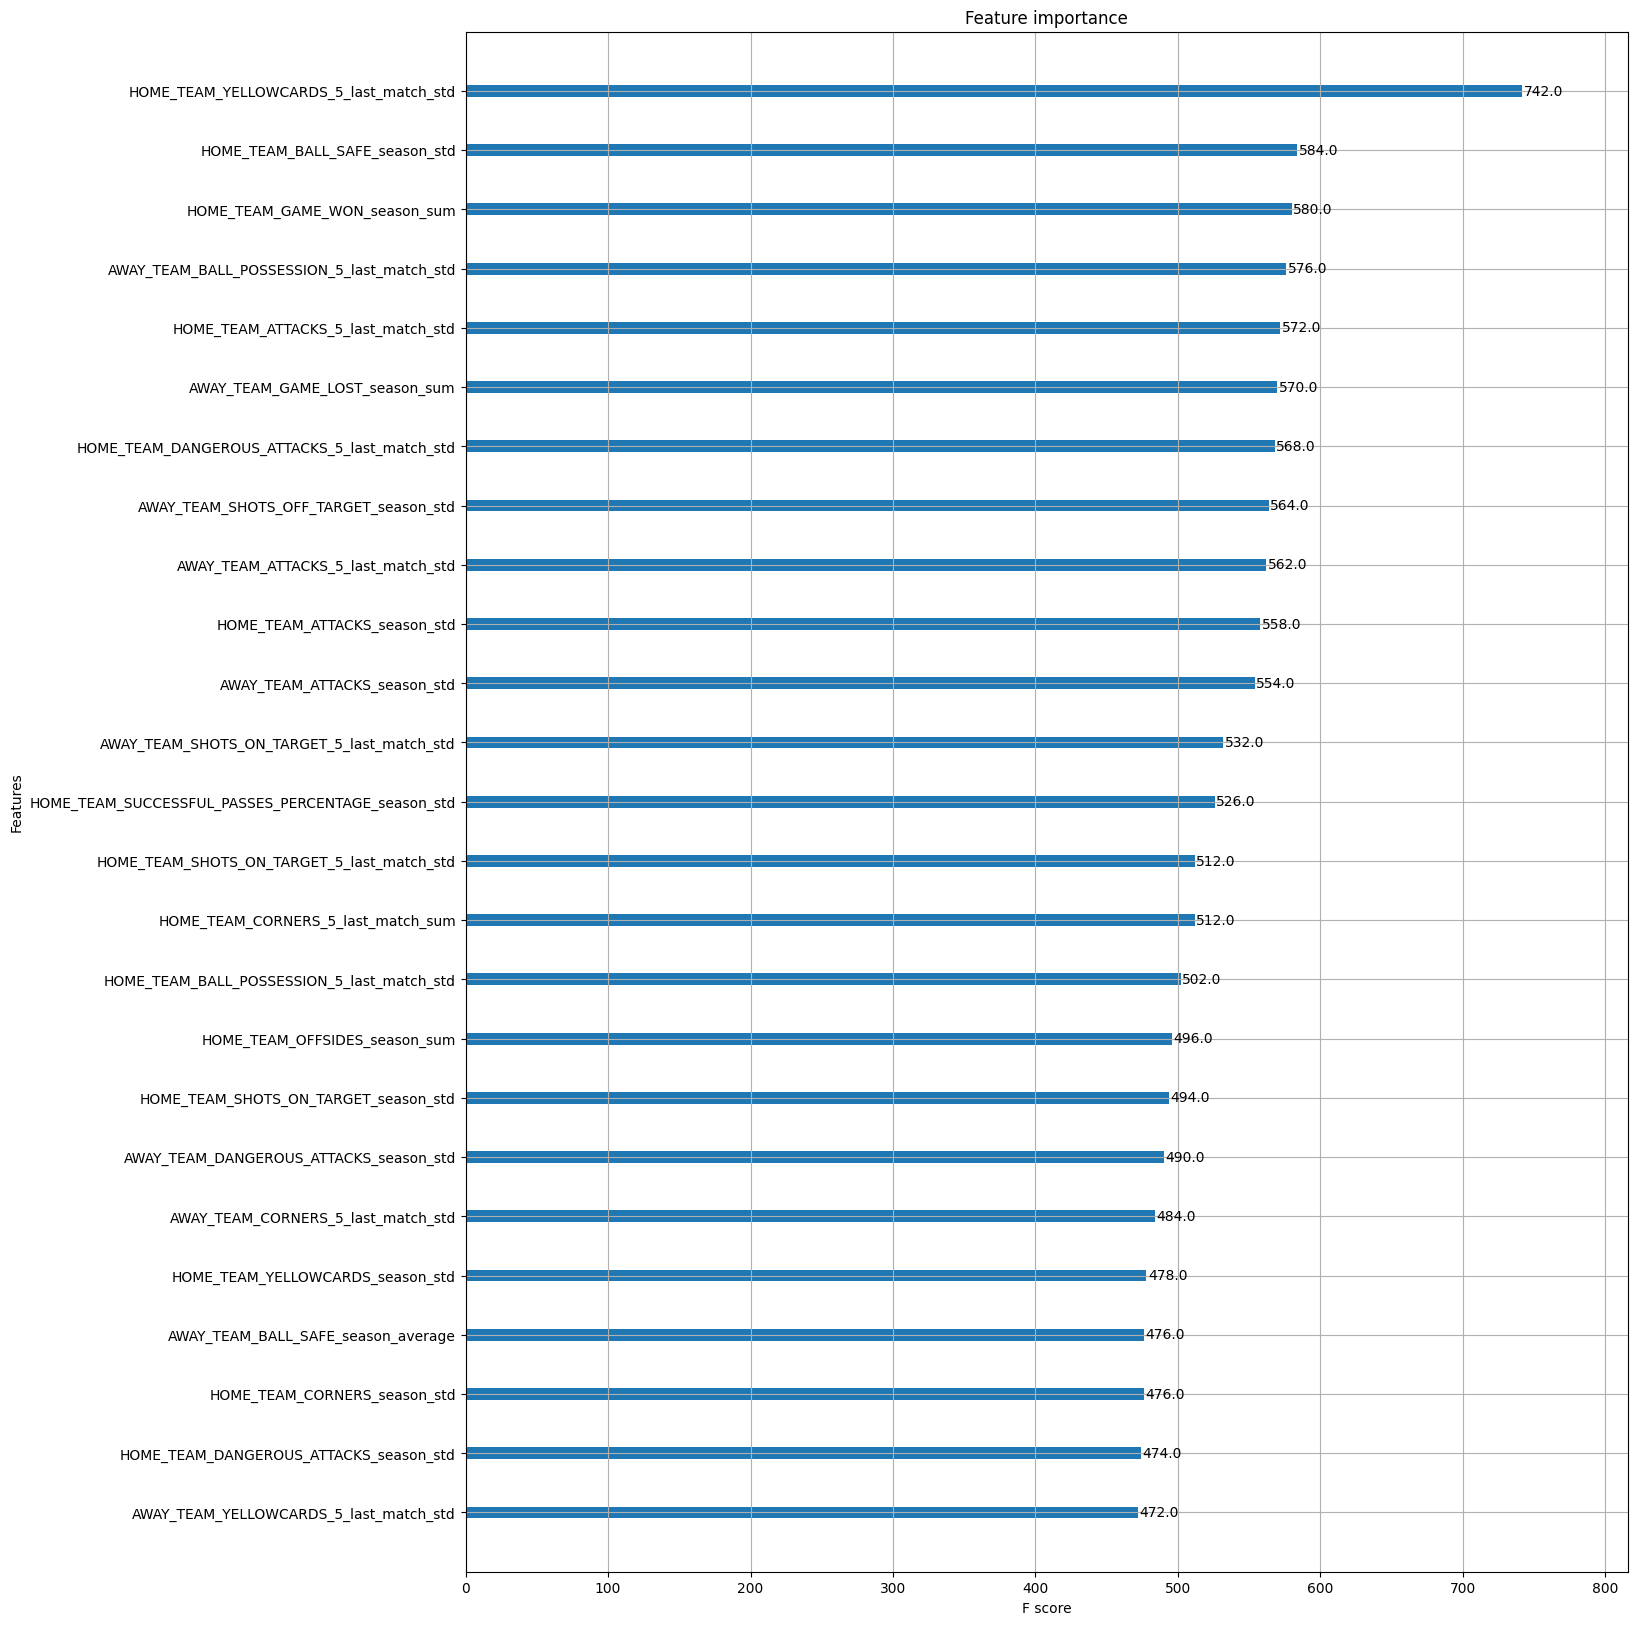

In [13]:
xgb.plot_importance(bst, max_num_features=25)
fig = plt.gcf()
fig.set_size_inches(15, 20)


### Accuracy on test set

A simple benchmark is always predicting home wins

In [31]:
target = train_scores.loc[X_test.index].copy()

home_wins = target
home_wins = 0 * home_wins
home_wins.iloc[:,0] = 1

np.round(accuracy_score(home_wins,target),4)


0.4401

Using our model

In [32]:
X_test_xgb = xgb.DMatrix(X_test)

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
np.round(accuracy_score(predictions,target),4)


0.4742

## Submission

In [36]:

test_home = pd.read_csv('./datas_final/test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('./datas_final/test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)


In [53]:
X_bench = xgb.DMatrix(test_data)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int)

predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = test_data.index
submission = predictions.reset_index()
submission.to_csv('./datas_final/benchmark_submission.csv', index=False)
